In [55]:
import numpy as np
from Library import Convert_to_A_and_B, ka, Create_MPO, Pauli, Model_coefficients, Entropy, Create_random_MPS

def LRW_mult(v):
    return np.matmul(LRW,v)

def Exp_value_B(B, L, W, v_L, v_R):
  Env = np.einsum("a,b,c->abc",B[0],v_L,B[0])
  
  for j in range(1,L+1):
    Env = np.einsum("abc,ajd->djbc",Env,B[j])
    Env = np.einsum("djbc,beji->deic",Env,W)
    Env = np.einsum("deic,cif->def",Env,np.conj(B[j]))
  Energy = np.einsum("ded,e->",Env,v_R)
  return Energy.real

def New_Energy(L_env,B,W,R_env):
  Energy = np.einsum("abc,aid->dibc",L_env,B)
  Energy = np.einsum("dibc,beij->dejc",Energy,W)
  Energy = np.einsum("dejc,def->cjf",Energy,R_env)
  Energy = np.einsum("cjf,cjf->",Energy,np.conj(B))
  return Energy.real
  
def Update_L(L_env,A,W):
    Lev = np.einsum("abc,ajd->jdbc",L_env,A)
    Lev = np.einsum("jdbc,beji->deci",Lev,W)
    Lev = np.einsum("deci,cif->def",Lev,np.conj(A))
    return Lev 
  


In [49]:
from numpy import linalg as LA
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import LinearOperator
import matplotlib.pyplot as plt

data_type=np.complex128
S_z, S_x, S_y, S1 = Pauli()

d = 2
L = 80        # system size
chi_max = 8          # Maximal bond dimension                            
#n = 10   # Number of zips
h_x, h_y, h_z = 0.1, 0.9, 0.1  # Field in the different directions
J_xx, J_yy, J_zz = 1., 0.2, 1  # Strength of spin interactions
Model = [["x"],["z"]]     # The first part of the model gives us the spin interaction and the second one the fields
chi_MPO = len(Model[0]) + 2 

Interactions, Fields = Model_coefficients(J_xx,J_yy,J_zz,h_x,h_y,h_z)
          
chis = ka(L,chi_max)

# Create MPO
W = Create_MPO(Model, S1, Interactions, Fields, chi_MPO, data_type)
# Create the MPS
Gamma,Lambda = Create_random_MPS(L,chis)
# Convert to right and left A,B canonical form
A,B = Convert_to_A_and_B(Gamma,Lambda,L)
B[0] = np.array([1.])

# Left and Right vectors
v_L,v_R=np.zeros(chi_MPO,dtype=np.complex_),np.zeros(chi_MPO,dtype=np.complex_)
v_L[0],v_R[-1]=1.+0j,1.+0j

# Initialise Left and Right environments
L_env=[np.zeros((chis[j],chi_MPO,chis[j]),dtype=np.complex_)for j in range(L+1)]
R_env=[np.zeros((chis[j],chi_MPO,chis[j]),dtype=np.complex_)for j in range(L+1)]

L_env[0]=np.array(np.einsum("ab,c->acb",np.eye(chis[0],dtype=np.complex_),v_L))
R_env[-1]=np.einsum("ab,c->acb",np.eye(chis[-1],dtype=np.complex_),v_R)

# Set the Right environment
for j in range(L-1,0,-1):    
     R_env[j]=np.einsum("ebji,dja->debia",W,B[j+1])
     R_env[j]=np.einsum("fic,debia->debfca",np.conj(B[j+1]),R_env[j])
     R_env[j]=np.einsum("abc,debfca->def",R_env[j+1],R_env[j])
# Calculating the inverse of the singular values 
vi=[]
for j in range(len(Lambda)):
  vi.append(np.divide(1.0, Lambda[j], out=np.zeros_like(Lambda[j]), where=np.abs(Lambda[j])>=1E-14))
vi.append([1.])
i = 0
print(chis[i],chis[i+2],"chis1")
print(L_env[i].shape,B[i+2].shape,R_env[i].shape)
print(chis[i])
print(A[i].shape)


1 4 chis1
(1, 3, 1) (2, 2, 4) (1, 3, 1)
1
(1, 2, 2)


In [73]:
M = []
delta = 2
step = 0
lambda_p = []
alpha = 0.9
while np.abs(delta)>10E-9 and step<40:
  print("step",step)
  #print("Mixer step:",step)
  for j in range(L-1):
    #"print("site",j)
   
    # Optimize the tensor Mi
    LRW = np.einsum("abc,bdij -> adijc",R_env[j+1],W) 
    LRW = np.einsum("adijc,vdm-> avijcm",LRW,L_env[j]).reshape((chis[j]*chis[j+1]*d,chis[j]*chis[j+1]*d))
     
    if step < 1 :
     w, v = LA.eigh(LRW)
     lambdap = w[0]
     M.append(v[:,0])
    else:
     O = LinearOperator((chis[j]*chis[j+1]*d,chis[j]*chis[j+1]*d), matvec = LRW_mult)
     w, v = eigsh(O,k=1,v0 = M[j] ,which= "SA",maxiter = 100000,tol=10E-9)
     lambdap = w[0]
     M[j] = v[:,0] 
    M_p = M[j].reshape((chis[j],d,chis[j+1]))
     
    Pi = alpha*np.einsum("abc,aid -> cibd", L_env[j], M_p)
    Pi = np.einsum("cibd,bkij->ckjd",Pi,W)
    
    Zero_block = np.zeros((chis[j+1],chi_MPO,d,chis[j+2]))
    
    # Where do I update gamma, why do I use Gamma?
    
    B_block = np.array([B[j+2],Zero_block[:,0,:,:],Zero_block[:,1,:,:],Zero_block[:,2,:,:]]).reshape(d*chis[j+1],(1+chi_MPO)*chis[j+2])
    M_block_p = np.array([M_p,Pi[:,0,:,:],Pi[:,1,:,:],Pi[:,2,:,:]]).reshape(d*chis[j],(1+chi_MPO)*chis[j+1])
   
    
    S,V,D = LA.svd(M_block_p,full_matrices = False)
   
    A[j] = S[:,:chis[j+1]].reshape(chis[j],d,chis[j+1])
    VD = np.einsum("a,ab->ab",V[:chis[j+1]],D[:chis[j+1],:d*chis[j+1]])         # chis[j+1] x d*chis[j+1]
    B[j+2] = np.einsum("ab,bh -> ah ",VD,B_block)[:,:d*chis[j+2]].reshape(chis[j+1],d,chis[j+2])   # chis[j+1] x (1+chi_MPO)*chis[j+1]
    
    #print(L_env[j].shape,"l I A")

    L_env[j+1] = Update_L(L_env[j],A[j],W)
    
    #print(L_env[j].shape,"L env J",B[j].shape)
    #print(A[j].shape,"A shape")
    #New_en = New_Energy(L_env[j],B[j],W,R_env[j+1])
   
  step+=1
  alpha *= alpha
  lambda_p.append(lambdap)
   

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39


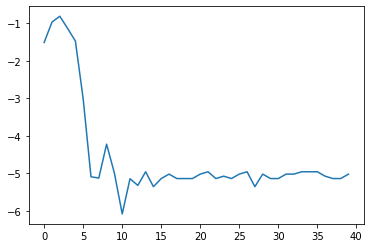

In [74]:
plt.plot(lambda_p)

In [44]:
D = np.arange(12).reshape(3,4)
Mu,Nu,Su = LA.svd(D,full_matrices=False)
print(Mu.shape)
print(Nu.shape)
print(Su.shape)

(3, 3)
(3,)
(3, 4)
